In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import kagglehub
import os
import joblib



In [2]:
path = kagglehub.dataset_download("ivansher/nasa-nearest-earth-objects-1910-2024")
print("Dataset downloaded to:", path)

Dataset downloaded to: C:\Users\User\.cache\kagglehub\datasets\ivansher\nasa-nearest-earth-objects-1910-2024\versions\2


In [3]:
dataset_path = r"c:\Users\User\Desktop\graduation project\nearest-earth-objects(1910-2024).csv"

In [4]:
try:
    df = pd.read_csv(dataset_path)
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: Dataset file not found. Please check the path.")
    exit()


Dataset loaded successfully!


In [5]:
print(df.head())
print(df.info())


    neo_id                name  absolute_magnitude  estimated_diameter_min  \
0  2162117  162117 (1998 SD15)               19.14                0.394962   
1  2349507    349507 (2008 QY)               18.50                0.530341   
2  2455415    455415 (2003 GA)               21.45                0.136319   
3  3132126           (2002 PB)               20.63                0.198863   
4  3557844           (2011 DW)               22.70                0.076658   

   estimated_diameter_max orbiting_body  relative_velocity  miss_distance  \
0                0.883161         Earth       71745.401048   5.814362e+07   
1                1.185878         Earth      109949.757148   5.580105e+07   
2                0.304818         Earth       24865.506798   6.720689e+07   
3                0.444672         Earth       78890.076805   3.039644e+07   
4                0.171412         Earth       56036.519484   6.311863e+07   

   is_hazardous  
0         False  
1          True  
2         Fals

In [6]:
# Handling missing values
def clean_data(df):
    df = df.copy()  # Avoid modifying the original DataFrame
    
    for col in df.columns:
        if df[col].dtype == 'object':  # If categorical
            df[col] = df[col].fillna(df[col].mode()[0])  # Fill categorical with mode
        else:  # If numerical
            df[col] = df[col].fillna(df[col].median())  # Fill numerical with median
    
    return df

df = clean_data(df)  # Apply the function



In [7]:
# Ensure data is not empty after cleaning
if df.empty:
    print("Error: Dataframe is empty after cleaning.")
    exit()

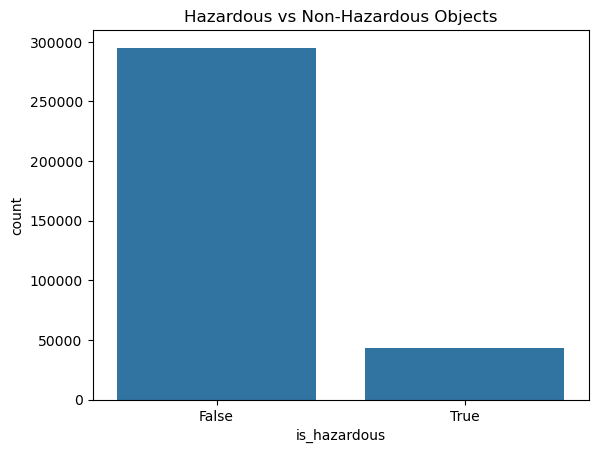

In [8]:
# Visualize distribution of hazardous vs non-hazardous objects
sns.countplot(x=df["is_hazardous"])
plt.title("Hazardous vs Non-Hazardous Objects")
plt.show()

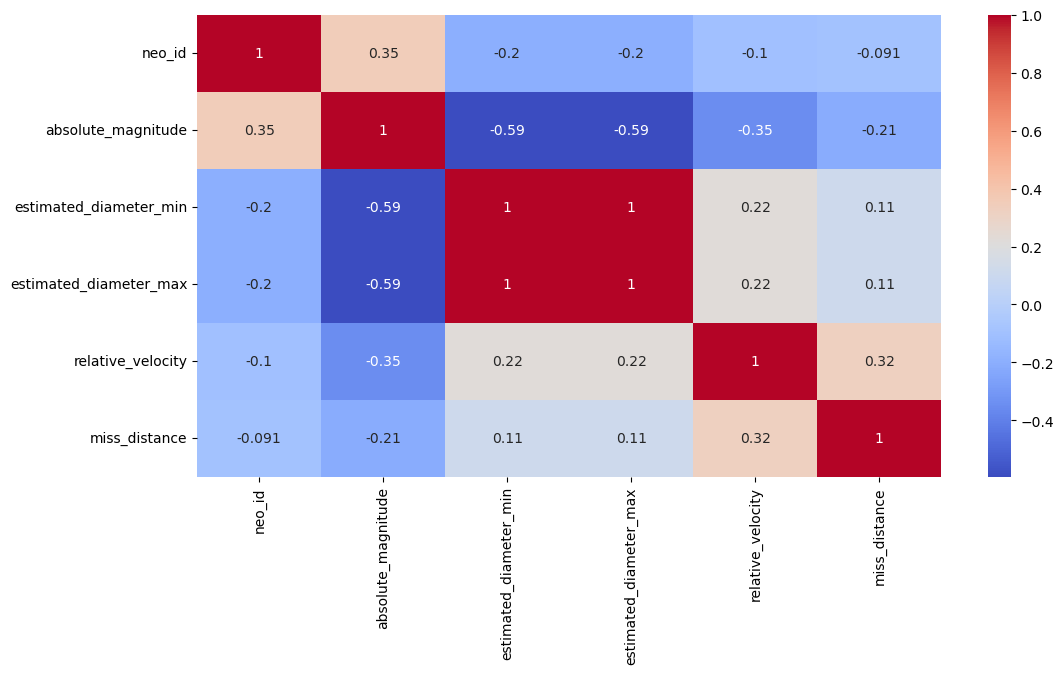

In [9]:
# Correlation heatmap (Only for numeric columns)
numeric_df = df.select_dtypes(include=[np.number])
if not numeric_df.empty:
    plt.figure(figsize=(12, 6))
    sns.heatmap(numeric_df.corr(), annot=True, cmap="coolwarm")
    plt.show()
else:
    print("No numeric columns available for correlation heatmap.")


In [10]:
# Ensure target column exists
if "is_hazardous" not in df.columns:
    print("Error: 'is_hazardous' column not found in dataset.")
    exit()


In [13]:
# Define features (X) and target (y)
y = df["is_hazardous"]
columns_to_drop = ["is_hazardous", "id", "name"]
X = df.drop(columns=[col for col in columns_to_drop if col in df.columns])

if X.empty:
    print("Error: Feature matrix is empty after dropping columns.")
    exit()

In [15]:
# Convert categorical columns to numerical using one-hot encoding
X = pd.get_dummies(X, drop_first=True)  # Convert categorical variables to numerical

In [16]:
# Feature Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [17]:
# Convert categorical columns to numerical using one-hot encoding
X = pd.get_dummies(X, drop_first=True)  # Convert categorical variables to numerical

# Normalize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [18]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [20]:
# Train a RandomForestClassifier model
model = RandomForestClassifier(class_weight="balanced", random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', random_state=42)

In [21]:
# Evaluate model performance
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print(classification_report(y_test, y_pred))
print("AUC-ROC Score:", roc_auc_score(y_test, y_proba))

              precision    recall  f1-score   support

       False       0.99      0.98      0.99     59182
        True       0.98      0.99      0.99     58833

    accuracy                           0.99    118015
   macro avg       0.99      0.99      0.99    118015
weighted avg       0.99      0.99      0.99    118015

AUC-ROC Score: 0.9988295041116947


In [22]:
# Save the trained model
joblib.dump(model, "neo_hazard_model.pkl")
print("Model saved as neo_hazard_model.pkl")


Model saved as neo_hazard_model.pkl
